# Анализ набора данных

Обратимся к общедоступным источникам.

**Lending club** — ведущий цифровой банк на рынке кредитования в США, опубликовал анонимизированные данные о кредитной истории заемщиков, которые мы в свою очередь сможем использовать для анализа и прогнозирования вероятности дефолта по займам.

Набор данных также может подойти для задачи многоклассовой классификации — для оценки кредитоспособности заемщиков

In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn.model_selection import (train_test_split,
                                     GridSearchCV,
                                     StratifiedKFold,
                                     cross_val_score)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score,
                             recall_score,
                             precision_score,
                             f1_score,
                             roc_auc_score)
from sklearn.metrics import classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from scipy import stats
from sklearn.base import clone
%matplotlib inline

In [ ]:
df = pd.read_csv('*/lending_club_loan_two.csv')

# переименование переменных
rename_dict = {
    'loan_amnt': 'сумма_займа',
    'int_rate': 'процентная_ставка',
    'installment': 'ежемесячный_платеж',
    'annual_inc': 'годовой_доход',
    'dti': 'ПДН',
    'open_acc': 'кол-во_открытых_счетов',
    'pub_rec': 'общественные_архивы', ## записи_в_гос_архивах
    'revol_bal': 'остаток_на_кредитных_картах',
    'revol_util': 'использование_кредитного_лимита',
    'total_acc': 'общее_количество_счетов',
    'mort_acc': 'количество_ипотечных_счетов',
    'pub_rec_bankruptcies': 'банкротство',
    'term': 'срок_займа',
    'grade': 'кредитный_рейтинг', # !!!
    'sub_grade': 'подрейтинг',
    'emp_length': 'стаж',
    'home_ownership': 'тип_владения_недвиж',
    'verification_status': 'статус_верификации',
    'loan_status': 'статус_займа', # !!!
    'purpose': 'цель_займа',
    'initial_list_status': 'начальный_статус_заявки',
    'application_type': 'тип_заявки',
    'emp_title': 'род_деятельности',
    'title': 'тип_займа',
    'address': 'адрес',
    'issue_d': 'дата_выдачи',
    'earliest_cr_line': 'дата_начала_кредитной_истории'
}
df.rename(columns=rename_dict, inplace=True)
df.head()

,сумма_займа,срок_займа,процентная_ставка,ежемесячный_платеж,кредитный_рейтинг,подрейтинг,род_деятельности,стаж,тип_владения_недвиж,годовой_доход,...,кол-во_открытых_счетов,общественные_архивы,остаток_на_кредитных_картах,использование_кредитного_лимита,общее_количество_счетов,начальный_статус_заявки,тип_заявки,количество_ипотечных_счетов,банкротство,адрес
0,10000.0,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.0,...,16.0,0.0,36369.0,41.8,25.0,w,INDIVIDUAL,0.0,0.0,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.0,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.0,...,17.0,0.0,20131.0,53.3,27.0,f,INDIVIDUAL,3.0,0.0,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.0,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.0,...,13.0,0.0,11987.0,92.2,26.0,f,INDIVIDUAL,0.0,0.0,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.0,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.0,...,6.0,0.0,5472.0,21.5,13.0,f,INDIVIDUAL,0.0,0.0,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.0,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.0,...,13.0,0.0,24584.0,69.8,43.0,f,INDIVIDUAL,1.0,0.0,"679 Luna Roads\r\nGreggshire, VA 11650"


## **Основная информация**

Набор данных содержит информацию об около 400k заемщиках.

12 **количественных** переменных:

*   **сумма_займа**
*   **процентная_ставка**
*   **ежемесячный_платеж**: общий платеж по всем долговым обязательствам
*   **годовой_доход**: общий годовой доход заемщика, включая все источники дохода
*   **ПДН**: *показатель долговой нагрузки*, отражает соотношение между суммой ежемесячных платежей по всем кредитам и общим ежемесячным доходом заемщика
*   **кол-во_открытых_счетов**: кредитных счетов
*   **общественные_архивы**: количество архивов о заемщике в открытом доступе
*   **остаток_на_кредитных_картах**: текущий остаток на кредитных картах заемщика
*   **использование_кредитного_лимита**: процент использования кредитного лимита на кредитных картах
*   **общее_количество_счетов**: общее количество всех финансовых счетов заемщика
*   **количество_ипотечных_счетов**
*   **банкротство**: количество

10 **категориальных** переменных:

*   **срок_займа**
*   **кредитный_рейтинг** (класс кредитоспособности заемщика): отражает способность выплачивать долг
*   **подрейтинг**: более детальная категория кредитоспособности, дополняющая основной рейтинг
*   **стаж**: число лет опыта работы
*   **тип_владения_недвижимостью**: собственность, аренда или ипотека
*   **статус_верификации**: статус проверки предоставленных заемщиком данных.
*   **статус_займа**: текущий статус займа (выплаченный, просроченный и т.д.)
*   **цель_займа**
*   **начальный_статус_заявки**
*   **тип_заявки**

3 **текстовые** переменные:

*   **адрес**
*   **тип_займа**
*   **род_деятельности**

2 переменные типа **Datetime**:

*   **дата_выдачи**
*   **дата_начала_кредитной_истории**


---


0,8% пропущенных значений от общего числа значений

Дубликатов нет

# Предобработка данных

## **Шум и экстремальные значения**

Нет необходимости удалять экстремальные значения перед началом анализа, поскольку встреча с ними возможна в реальности.
Однако, если мы ошибочно приравняем выбросы к экстремальным значениям, то можем исказить выводы. Сначала обратим внимание на самые сомнительные показатели

**Переменные**

Показатель **эксцесса** — это мера формы распределения, которая помогает оценить отклонение от нормального распределения.

*   *Если значение эксцесса больше 3, то это может указывать на наличие выбросов в данных.*

Большой эксцесс означает, что данные имеют более высокую концентрацию в хвостах распределения, что может быть вызвано наличием аномальных значений или выбросов.

**Показатель долговой нагрузки (Kurtosis=237923)**

Так как этот показатель обычно представляет собой некий процент, разброс значений также вызывает подозрения

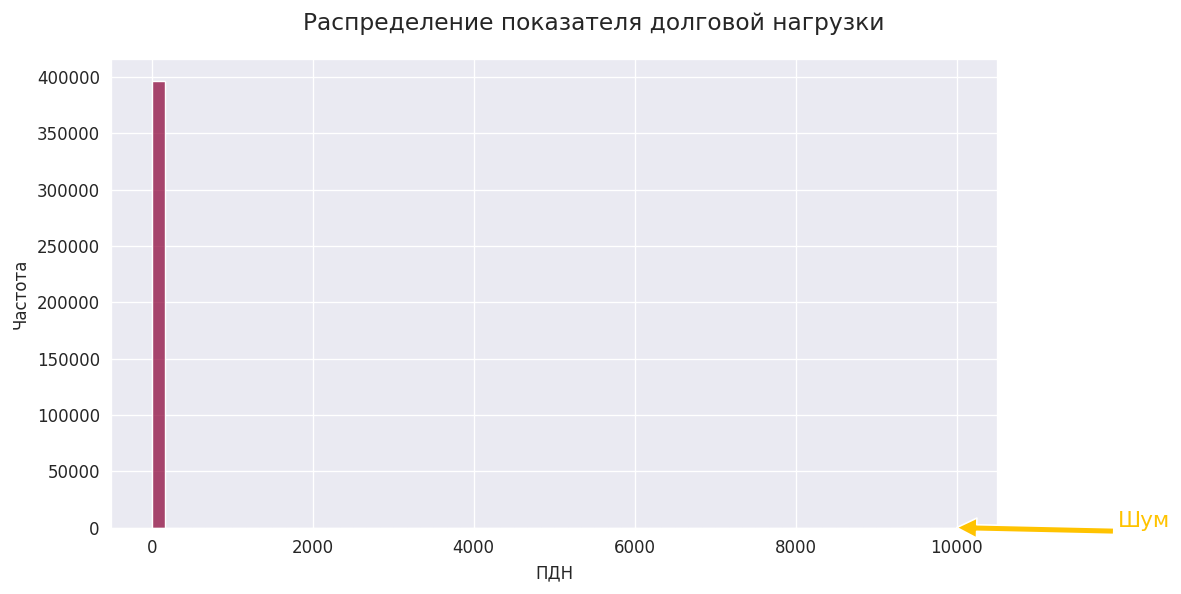

In [ ]:
sns.set_style('darkgrid')
color = '#900C3F'
arrow_color='#FFC300'

plt.figure(figsize=(10,5), dpi=120)
graph = sns.histplot(x='ПДН', data=df, bins=60, color=color)

plt.annotate('Шум', xy=(10000,60), xytext=(12000,400), color=arrow_color, fontsize=13,
             arrowprops=dict(facecolor=arrow_color, shrink=0.0003))
plt.xlabel('ПДН', fontsize=10)
plt.ylabel('Частота', fontsize=10)
plt.suptitle('Распределение показателя долговой нагрузки', fontsize=14)
plt.tight_layout()
plt.show()

Поскольку число таких отклоняющихся значений 8 занимает 0% от общего числа заемщиков (400k) при округлении уместно подозревать ошибки при заполнении данных

In [ ]:
high_dti_values = df.loc[df["ПДН"] > 100]
high_dti_values.loc[:, "> 100"] = [f"Заемщик {x+1}" for x in range(len(high_dti_values))]
high_dti_values[["> 100", "ПДН"]]

<ipython-input-5-6bd6386b2a7c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_dti_values.loc[:, "> 100"] = [f"Заемщик {x+1}" for x in range(len(high_dti_values))]


,> 100,ПДН
7011,Заемщик 1,189.90
36015,Заемщик 2,145.65
264045,Заемщик 3,107.55
285674,Заемщик 4,9999.00
294182,Заемщик 5,120.66
296164,Заемщик 6,138.03
338571,Заемщик 7,380.53
350865,Заемщик 8,1622.00


Предположим, что некоторые показатели вычислены неверно. Заново вычислим их по формуле

In [ ]:
# Вычисляем показатель DTI (ПДН) самостоятельно
high_dti_values['ПДН'] = (high_dti_values['ежемесячный_платеж'] / (high_dti_values['годовой_доход'] / 12) * 100).round(2)

# Выводим по-прежнему отклоняющиеся
incorrect_dti = high_dti_values[high_dti_values["ПДН"] > 100]
incorrect_dti[["> 100", "ПДН"]]

<ipython-input-6-ad75cd45a031>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_dti_values['ПДН'] = (high_dti_values['ежемесячный_платеж'] / (high_dti_values['годовой_доход'] / 12) * 100).round(2)


,> 100,ПДН
7011,Заемщик 1,265.33
285674,Заемщик 4,inf
338571,Заемщик 7,113.30
350865,Заемщик 8,1529.98


Итак, 4 значения по-прежнему превышают 100, что может говорить об ошибках при указании ежемесячного платежа и годового дохода. Например, ежемесячный платеж  **заемщика под номером 8** сильно превышает его ежемесячный доход.

Что интересно, при этом указано, что все счета оплачены своевременно

In [ ]:
# Заемщик 8
target_payment = high_dti_values['ежемесячный_платеж'][350865]
target_payment

764.99

In [ ]:
income_per_month = high_dti_values['годовой_доход'][350865] / 12
income_per_month

50.0

In [ ]:
# Определяем диапазон вариации: 10% от целевого платежа
variation_range = target_payment * 0.1

# Условие для проверки, попадает ли ежемесячный платеж в диапазон
condition = (df['ежемесячный_платеж'] >= (target_payment - variation_range)) & \
            (df['ежемесячный_платеж'] <= (target_payment + variation_range))

# Вычисляем средний показатель доходов (без учета аномальных выбросов)
df_cleared = df[df["ПДН"] <= 100]
average_income = df_cleared[condition]['годовой_доход'].mean()

# Отображаем результат
print(f"Средний годовой доход для заемщиков с аналогичной суммой платежа: {(average_income).round()}")
high_dti_values.loc[350865, 'годовой_доход'] = (average_income).round()
high_dti_values.loc[350865, 'ПДН'] = (high_dti_values.loc[350865, 'ежемесячный_платеж'] / (high_dti_values.loc[350865, 'годовой_доход'] / 12) * 100).round(2)
print(f"Показатель ПДН для 8 заемщика: {high_dti_values['ПДН'][350865]}")

Средний годовой доход для заемщиков с аналогичной суммой платежа: 102139.0
Показатель ПДН для 8 заемщика: 8.99


<ipython-input-9-d9dc7f03a462>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  average_income = df_cleared[condition]['годовой_доход'].mean()


У **четвертого заемщика** отсутствует информация о доходах.

Заменим показатель средним значением для данной категории кредитного рейтинга.

In [ ]:
# Заемщик 4
high_dti_values['ежемесячный_платеж'][285674]

123.94

In [ ]:
high_dti_values['подрейтинг'][285674]

'C2'

In [ ]:
# Вычисляем средний показатель (без учета аномальных выбросов)
df_cleared = df[df["ПДН"] <= 100]
average_income = df_cleared[df_cleared['подрейтинг'] == 'C2']['годовой_доход'].mean()
print(f"Средний годовой доход для заемщиков с рейтингом C2: {(average_income).round()}")

# Присваиваем средний годовой доход по данному индексу
high_dti_values.loc[285674, 'годовой_доход'] = 71034
high_dti_values.loc[285674, 'ПДН'] = (high_dti_values.loc[285674, 'ежемесячный_платеж'] / (high_dti_values.loc[285674, 'годовой_доход'] / 12) * 100).round(2)
print(f"Показатель ПДН для 4 заемщика: {high_dti_values['ПДН'][285674]}")

Средний годовой доход для заемщиков с рейтингом C2: 71034.0
Показатель ПДН для 4 заемщика: 2.09


In [ ]:
# Выводим по-прежнему отклоняющихся
incorrect_dti = high_dti_values[high_dti_values["ПДН"] > 100]
incorrect_dti[["> 100", "ПДН"]]

,> 100,ПДН
7011,Заемщик 1,265.33
338571,Заемщик 7,113.30


Заемщик 1 также указал несоразмерно низкий доход :)

In [ ]:
# Заемщик 1
high_dti_values.loc[7011, 'годовой_доход']

2500.0

In [ ]:
target_payment = high_dti_values.loc[7011, 'ежемесячный_платеж']
target_payment

552.77

In [ ]:
high_dti_values.loc[7011, 'статус_займа']

'Fully Paid'

In [ ]:
# Определяем диапазон вариации: 10% от целевого платежа
variation_range = target_payment * 0.1

# Условие для проверки, попадает ли ежемесячный платеж в диапазон
condition = (df['ежемесячный_платеж'] >= (target_payment - variation_range)) & \
            (df['ежемесячный_платеж'] <= (target_payment + variation_range))

# Вычисляем средний показатель доходов (без учета аномальных выбросов)
df_cleared = df[df["ПДН"] <= 100]
average_income = df_cleared[condition]['годовой_доход'].mean()

# Отображаем результат
print(f"Средний годовой доход для заемщиков с аналогичной суммой платежа: {(average_income).round()}")
high_dti_values.loc[7011, 'годовой_доход'] = (average_income).round()
high_dti_values.loc[7011, 'ПДН'] = (high_dti_values.loc[7011, 'ежемесячный_платеж'] / (high_dti_values.loc[7011, 'годовой_доход'] / 12) * 100).round(2)
print(f"Показатель ПДН для 8 заемщика: {high_dti_values['ПДН'][7011]}")

Средний годовой доход для заемщиков с аналогичной суммой платежа: 79113.0
Показатель ПДН для 8 заемщика: 8.38


<ipython-input-17-365951e8bed8>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  average_income = df_cleared[condition]['годовой_доход'].mean()


In [ ]:
# Выводим по-прежнему отклоняющихся
incorrect_dti = high_dti_values[high_dti_values["ПДН"] > 100]
incorrect_dti[["> 100", "ПДН"]]

,> 100,ПДН
338571,Заемщик 7,113.3


In [ ]:
# Заемщик 7
high_dti_values.loc[338571, 'годовой_доход']

5000.0

In [ ]:
target_payment = high_dti_values.loc[338571, 'ежемесячный_платеж']
target_payment

472.1

In [ ]:
high_dti_values.loc[338571, 'статус_займа']

'Fully Paid'

In [ ]:
# Определяем диапазон вариации: 10% от целевого платежа
variation_range = target_payment * 0.1

# Условие для проверки, попадает ли ежемесячный платеж в диапазон
condition = (df['ежемесячный_платеж'] >= (target_payment - variation_range)) & \
            (df['ежемесячный_платеж'] <= (target_payment + variation_range))

# Вычисляем средний показатель доходов (без учета аномальных выбросов)
df_cleared = df[df["ПДН"] <= 100]
average_income = df_cleared[condition]['годовой_доход'].mean()

# Отображаем результат
print(f"Средний годовой доход для заемщиков с аналогичной суммой платежа: {(average_income).round()}")
high_dti_values.loc[338571, 'годовой_доход'] = (average_income).round()
high_dti_values.loc[338571, 'ПДН'] = (high_dti_values.loc[338571, 'ежемесячный_платеж'] / (high_dti_values.loc[338571, 'годовой_доход'] / 12) * 100).round(2)
print(f"Показатель ПДН для 8 заемщика: {high_dti_values['ПДН'][338571]}")

Средний годовой доход для заемщиков с аналогичной суммой платежа: 75822.0
Показатель ПДН для 8 заемщика: 7.47


<ipython-input-22-03d9b85f9358>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  average_income = df_cleared[condition]['годовой_доход'].mean()


In [ ]:
high_dti_values[["ПДН", "ежемесячный_платеж", "годовой_доход", "статус_займа"]]

,ПДН,ежемесячный_платеж,годовой_доход,статус_займа
7011,8.38,552.77,79113.0,Fully Paid
36015,47.85,318.98,8000.0,Fully Paid
264045,24.12,134.09,6672.0,Fully Paid
285674,2.09,123.94,71034.0,Charged Off
294182,72.14,523.00,8700.0,Fully Paid
296164,34.62,461.60,16000.0,Fully Paid
338571,7.47,472.10,75822.0,Fully Paid
350865,8.99,764.99,102139.0,Fully Paid


**Замена значений исходного набора данных новыми**

In [ ]:
df_copy = df.copy()
df_copy.drop(high_dti_values.index, inplace=True)
df_copy = pd.concat([df_copy, high_dti_values], ignore_index=True)
df_copy.drop('> 100', axis=1, inplace=True)
df_copy.tail(3)

,сумма_займа,срок_займа,процентная_ставка,ежемесячный_платеж,кредитный_рейтинг,подрейтинг,род_деятельности,стаж,тип_владения_недвиж,годовой_доход,...,кол-во_открытых_счетов,общественные_архивы,остаток_на_кредитных_картах,использование_кредитного_лимита,общее_количество_счетов,начальный_статус_заявки,тип_заявки,количество_ипотечных_счетов,банкротство,адрес
396027,14000.0,36 months,11.49,461.60,B,B5,Medical Asst,4 years,MORTGAGE,16000.0,...,14.0,0.0,30504.0,66.2,36.0,w,JOINT,5.0,0.0,"PSC 5491, Box 7510\r\nAPO AE 22690"
396028,19000.0,60 months,16.99,472.10,D,D3,Distributer,1 year,MORTGAGE,75822.0,...,25.0,0.0,19104.0,33.3,62.0,f,JOINT,3.0,0.0,"1981 Johnson Extensions\r\nZacharyport, MN 30723"
396029,24000.0,36 months,9.16,764.99,B,B2,NaN,NaN,MORTGAGE,102139.0,...,16.0,0.0,24733.0,58.5,21.0,f,JOINT,2.0,0.0,"70599 Baker Curve Apt. 425\r\nAbbotthaven, NC ..."


In [ ]:
# Выводим по-прежнему отклоняющиеся
incorrect_dti = df_copy[df_copy["ПДН"] > 100]
incorrect_dti

,сумма_займа,срок_займа,процентная_ставка,ежемесячный_платеж,кредитный_рейтинг,подрейтинг,род_деятельности,стаж,тип_владения_недвиж,годовой_доход,...,кол-во_открытых_счетов,общественные_архивы,остаток_на_кредитных_картах,использование_кредитного_лимита,общее_количество_счетов,начальный_статус_заявки,тип_заявки,количество_ипотечных_счетов,банкротство,адрес


Мы победили!

## **Отрицательные значения**

Отрицательные значения могут указывать на ошибки в данных, которые могут исказить результаты статистического анализа. Такие значения встречаются в переменной банкротств. Мы заменим их на 0

In [ ]:
df_copy['банкротство'] = df_copy['банкротство'].apply(lambda x: 0 if x < 0 else x)
count_negative = df_copy['банкротство'].lt(0).sum()
print(f"Количество замененных значений: {df_copy['банкротство'].eq(0).sum()}")
print(f"Количество значений меньше 0 в колонке 'банкротство': {count_negative}")

Количество замененных значений: 350380
Количество значений меньше 0 в колонке 'банкротство': 0


## **Отсутствующие значения**

Заполним отсутствующие значения средними показателями

In [ ]:
df_copy['количество_ипотечных_счетов'] = df_copy['количество_ипотечных_счетов'].fillna(0.0)
df_copy['стаж'] = df_copy['стаж'].fillna('7 years')
df_copy['род_деятельности'] = df_copy['род_деятельности'].fillna('manager')

print(f"Количество пропущенных значений в столбце 'количество_ипотечных_счетов' после замены: {df_copy['количество_ипотечных_счетов'].isnull().sum()}")
print(f"Количество пропущенных значений в столбце 'стаж' после замены: {df_copy['стаж'].isnull().sum()}")
print(f"Количество пропущенных значений в столбце 'род_деятельности' после замены: {df_copy['род_деятельности'].isnull().sum()}")

Количество пропущенных значений в столбце 'количество_ипотечных_счетов' после замены: 0
Количество пропущенных значений в столбце 'стаж' после замены: 0
Количество пропущенных значений в столбце 'род_деятельности' после замены: 0


**Удаление выбросов банкротства**

Мы обратились к законодательству США и выяснили, что в стране накладывают ограничения на количество банкротств, которое может подать один человек. В целом, человек может подать заявление о банкротстве не более одного раза в течение 8 лет. Это означает, что после подачи первого заявления о банкротстве по главе 7 или главе 13 Кодекса о банкротстве США, человек должен подождать 8 лет, прежде чем он сможет подать еще одно заявление о банкротстве по той же главе. Это означает, что для подачи 4 банкротств потребуется как минимум 32 года.

Кроме того, мы обратили внимание на **опыт работы**: только люди с опытом более 10 лет могут попасть в обстоятельства двух и более банкротств

In [ ]:
incorrect_banc = df_copy[df_copy["банкротство"] > 2]
incorrect_banc['стаж'] = incorrect_banc['стаж'].fillna('7 years')
incorrect_banc.loc[(incorrect_banc['стаж'] == '< 1 year') |
                   (incorrect_banc['стаж'] == '1 year') |
                   (incorrect_banc['стаж'] == '2 years') |
                   (incorrect_banc['стаж'] == '3 years')|
                   (incorrect_banc['стаж'] == '4 years') |
                   (incorrect_banc['стаж'] == '5 years') |
                   (incorrect_banc['стаж'] == '6 years') |
                   (incorrect_banc['стаж'] == '7 years') |
                   (incorrect_banc['стаж'] == '8 years') |
                   (incorrect_banc['стаж'] == '9 years'), 'банкротство'] = 1
incorrect_banc.loc[(incorrect_banc['стаж'] == '10+ years') & (incorrect_banc["банкротство"] > 2), 'банкротство'] = 2

df_copy = df_copy.copy()
df_copy.drop(incorrect_banc.index, inplace=True)
df_copy = pd.concat([df_copy, incorrect_banc], ignore_index=True)

<ipython-input-28-2018d09bdbed>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_banc['стаж'] = incorrect_banc['стаж'].fillna('7 years')


## **Преобразование единиц измерения для сравнения: ежемесячных расходы в годовые**

приведем различные единицы измерений, используемые в разных признаках (**ежемесячные расходы по кредитным картам** и **сумма годового дохода**), к одному общему знаменателю, чтобы они были сопоставимы и могли быть проанализированы вместе

In [ ]:
df_copy['ежемесячный_платеж'] = df_copy['ежемесячный_платеж']*12
df_copy.rename(columns={'ежемесячный_платеж': 'ежегодный_платеж'}, inplace=True)

# Логарифмические  преобразования


Применив логарифмическую функцию к данным, мы можем сжать диапазон значений, сделав выбросы менее выраженными.
Такое преобразование может сделать данные более подходящими для анализа и улучшить производительность статистических моделей.

Рассмотрим другие переменные с большими эксцессами (Kurtosis > 2.8)

*   **годовой_доход** (Kurtosis=4238)
*   **кол-во_открытых_счетов** (Kurtosis=2.9)
*   **остаток_на_кредитных_картах** (Kurtosis=384)
*   **количество_ипотечных_счетов** (Kurtosis=4.4)
*   **общественные_архивы** (Kurtosis=1867)

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


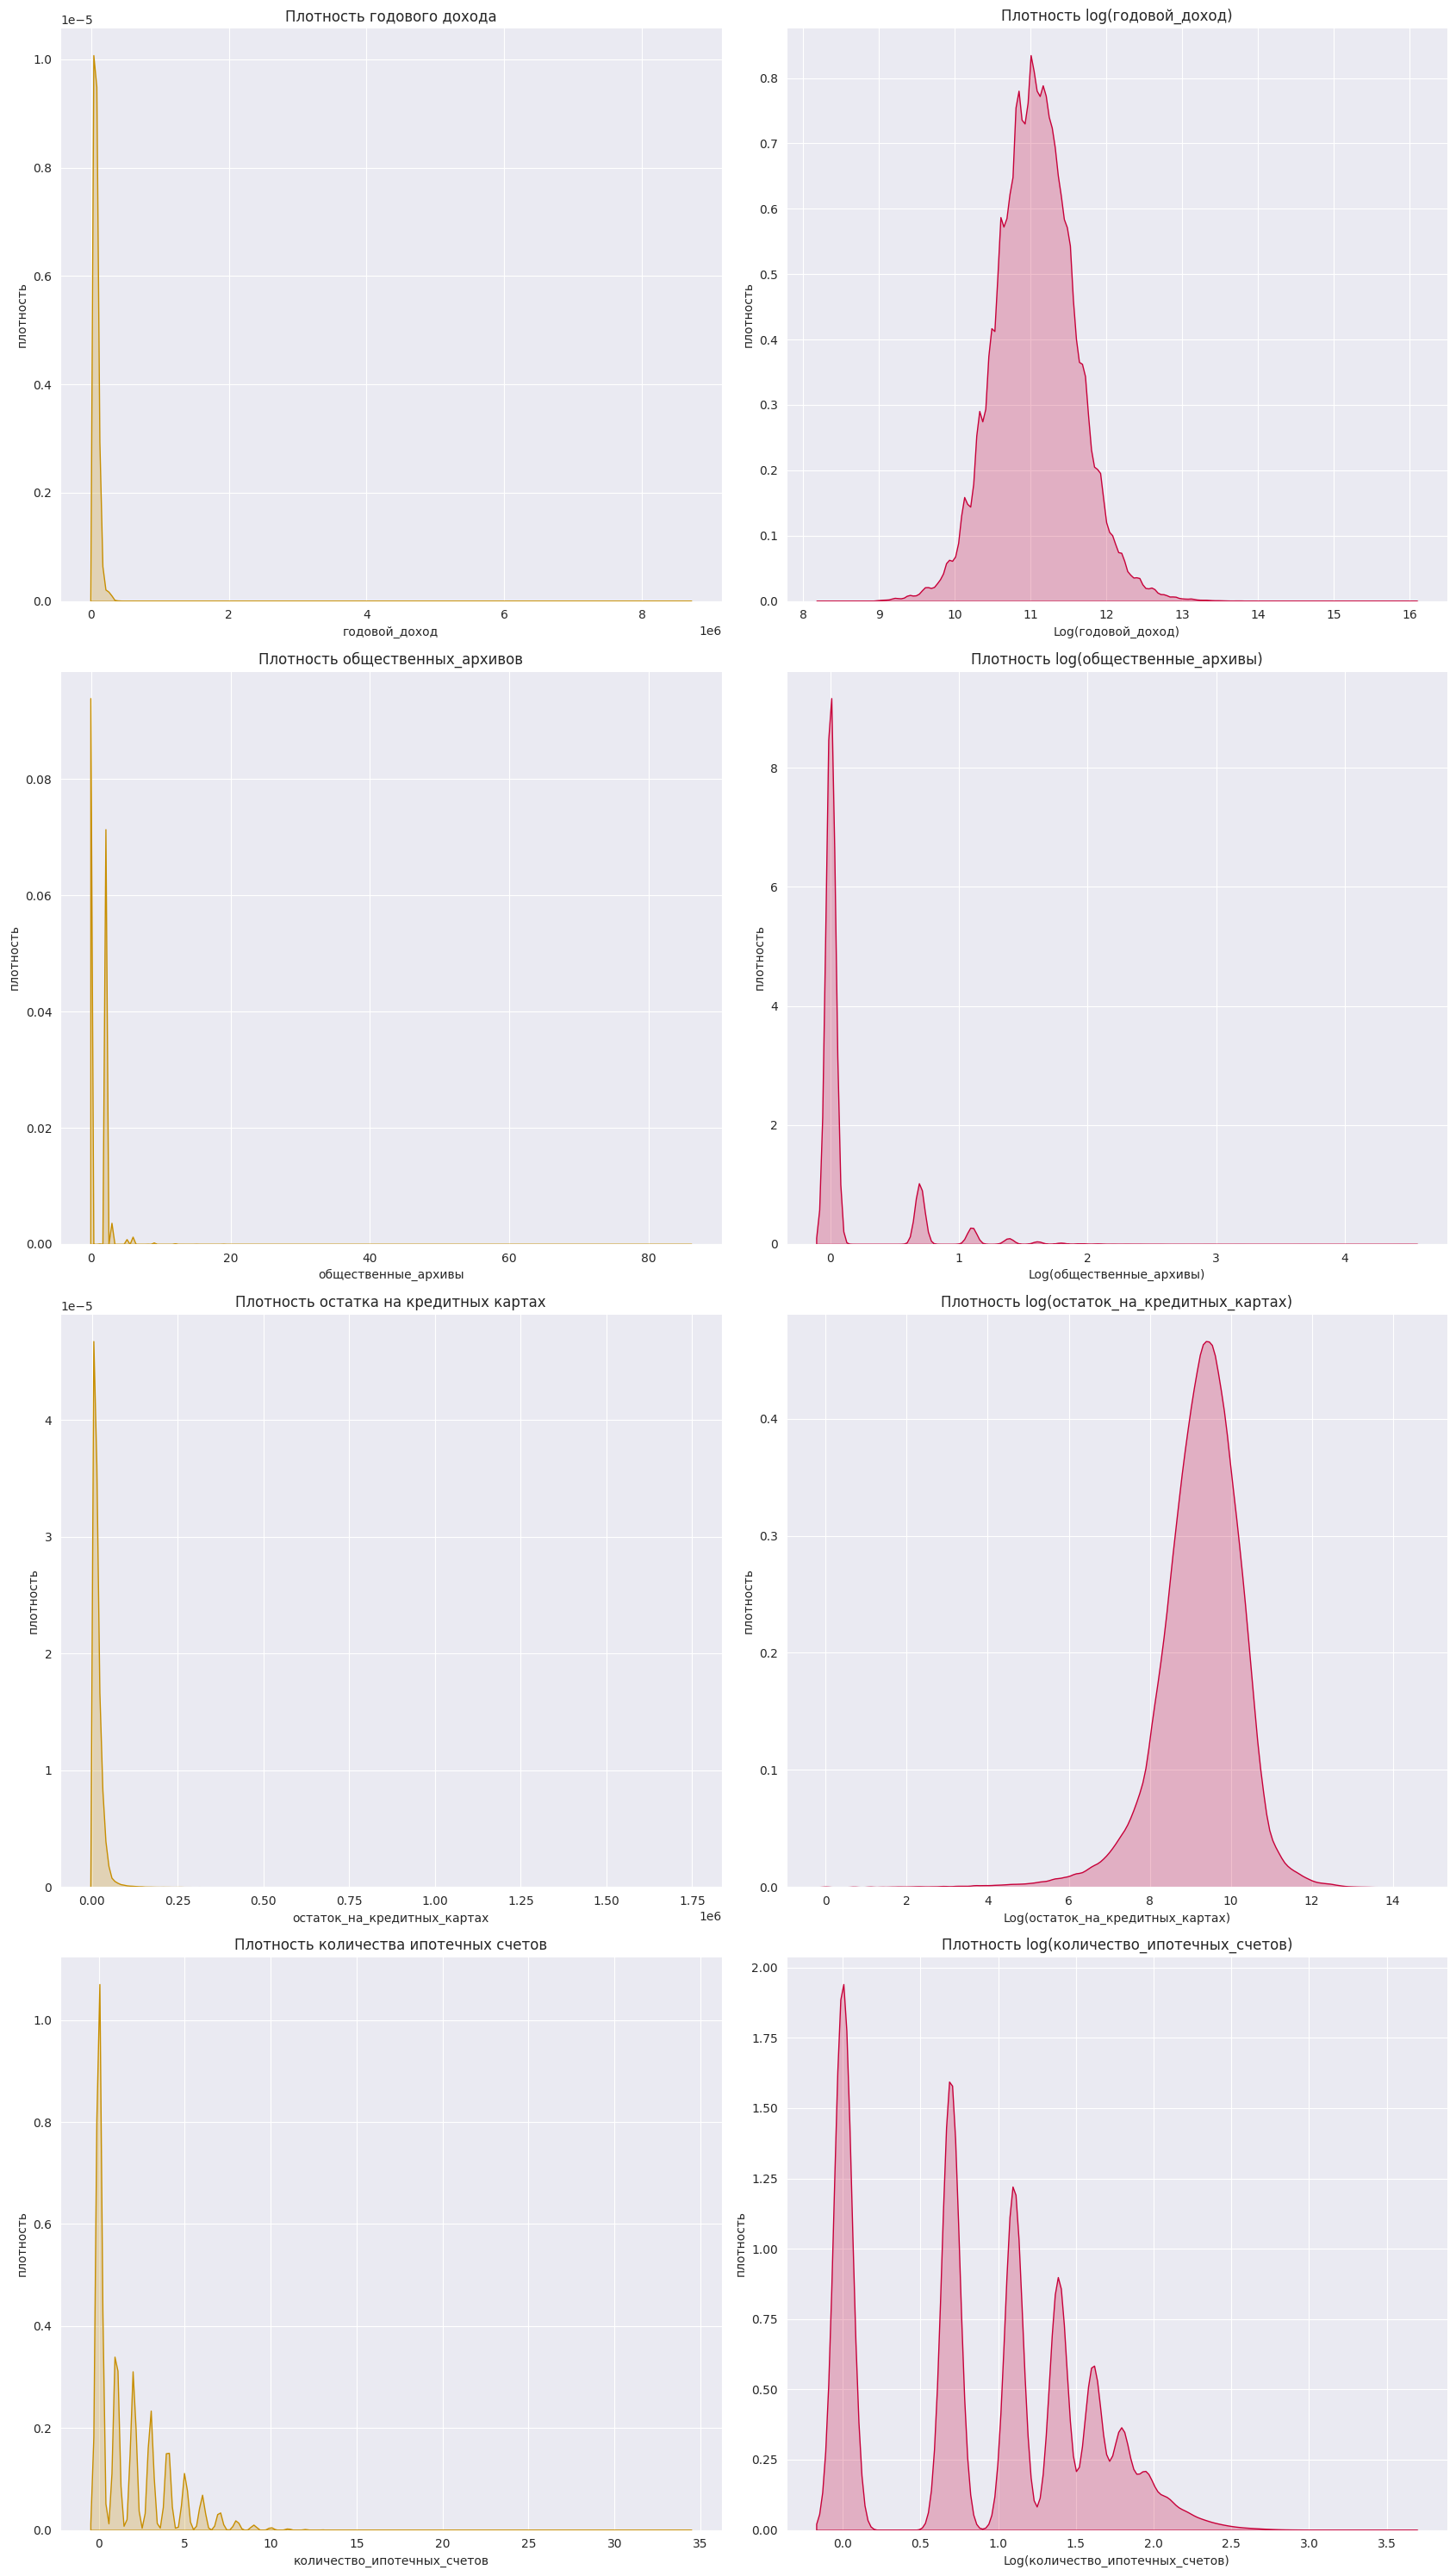

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Копия для логарифмизированного DataFrame
df_log = df_copy.copy()

color = '#c78e00'
log_color = '#C70039'

# Логарифмирование данных для всех переменных
df_copy['log_income'] = np.log(df_copy['годовой_доход'])
df_copy['log_archives'] = np.log(df_copy['общественные_архивы'])
df_copy['log_balance'] = np.log(df_copy['остаток_на_кредитных_картах'])
df_copy['log_mortgage_accounts'] = np.log(df_copy['количество_ипотечных_счетов'])

df_log['годовой_доход'] = np.log(df_copy['годовой_доход'])
df_log['общественные_архивы'] = np.log(df_copy['общественные_архивы'])
df_log['остаток_на_кредитных_картах'] = np.log(df_copy['остаток_на_кредитных_картах'])
df_log['количество_ипотечных_счетов'] = np.log(df_copy['количество_ипотечных_счетов'])

# Создание единого полотна
fig, axes = plt.subplots(4, 2, figsize=(17, 30))

sns.kdeplot(df_copy['годовой_доход'], fill=True, color=color, ax=axes[0, 0])
axes[0, 0].set_title('Плотность годового дохода')
axes[0, 0].set_xlabel('годовой_доход')
axes[0, 0].set_ylabel('плотность')

sns.kdeplot(df_copy['общественные_архивы'], fill=True, color=color, ax=axes[1, 0])
axes[1, 0].set_title('Плотность общественных_архивов')
axes[1, 0].set_xlabel('общественные_архивы')
axes[1, 0].set_ylabel('плотность')

sns.kdeplot(df_copy['остаток_на_кредитных_картах'], fill=True, color=color, ax=axes[2, 0])
axes[2, 0].set_title('Плотность остатка на кредитных картах')
axes[2, 0].set_xlabel('остаток_на_кредитных_картах')
axes[2, 0].set_ylabel('плотность')

sns.kdeplot(df_copy['количество_ипотечных_счетов'], fill=True, color=color, ax=axes[3, 0])
axes[3, 0].set_title('Плотность количества ипотечных счетов')
axes[3, 0].set_xlabel('количество_ипотечных_счетов')
axes[3, 0].set_ylabel('плотность')

sns.kdeplot(df_copy['log_income'], fill=True, color=log_color, ax=axes[0, 1])
axes[0, 1].set_title('Плотность log(годовой_доход)')
axes[0, 1].set_xlabel('Log(годовой_доход)')
axes[0, 1].set_ylabel('плотность')

sns.kdeplot(df_copy['log_archives'], fill=True, color=log_color, ax=axes[1, 1])
axes[1, 1].set_title('Плотность log(общественные_архивы)')
axes[1, 1].set_xlabel('Log(общественные_архивы)')
axes[1, 1].set_ylabel('плотность')

sns.kdeplot(df_copy['log_balance'], fill=True, color=log_color, ax=axes[2, 1])
axes[2, 1].set_title('Плотность log(остаток_на_кредитных_картах)')
axes[2, 1].set_xlabel('Log(остаток_на_кредитных_картах)')
axes[2, 1].set_ylabel('плотность')

sns.kdeplot(df_copy['log_mortgage_accounts'], fill=True, color=log_color, ax=axes[3, 1])
axes[3, 1].set_title('Плотность log(количество_ипотечных_счетов)')
axes[3, 1].set_xlabel('Log(количество_ипотечных_счетов)')
axes[3, 1].set_ylabel('плотность')

plt.tight_layout()

plt.show()

Графики KDE наглядно показывают, как логарифмическое **преобразование смягчает влияние экстремальных значений**.

Сжимая диапазон значений, логарифмические преобразования **повышают** **надежность** **статистического анализа и моделей**.

**Проверка на нормальность распределения после преобразований**

Чтобы выбрать корректные покатели вариативности следует проверить распределения на нормальность

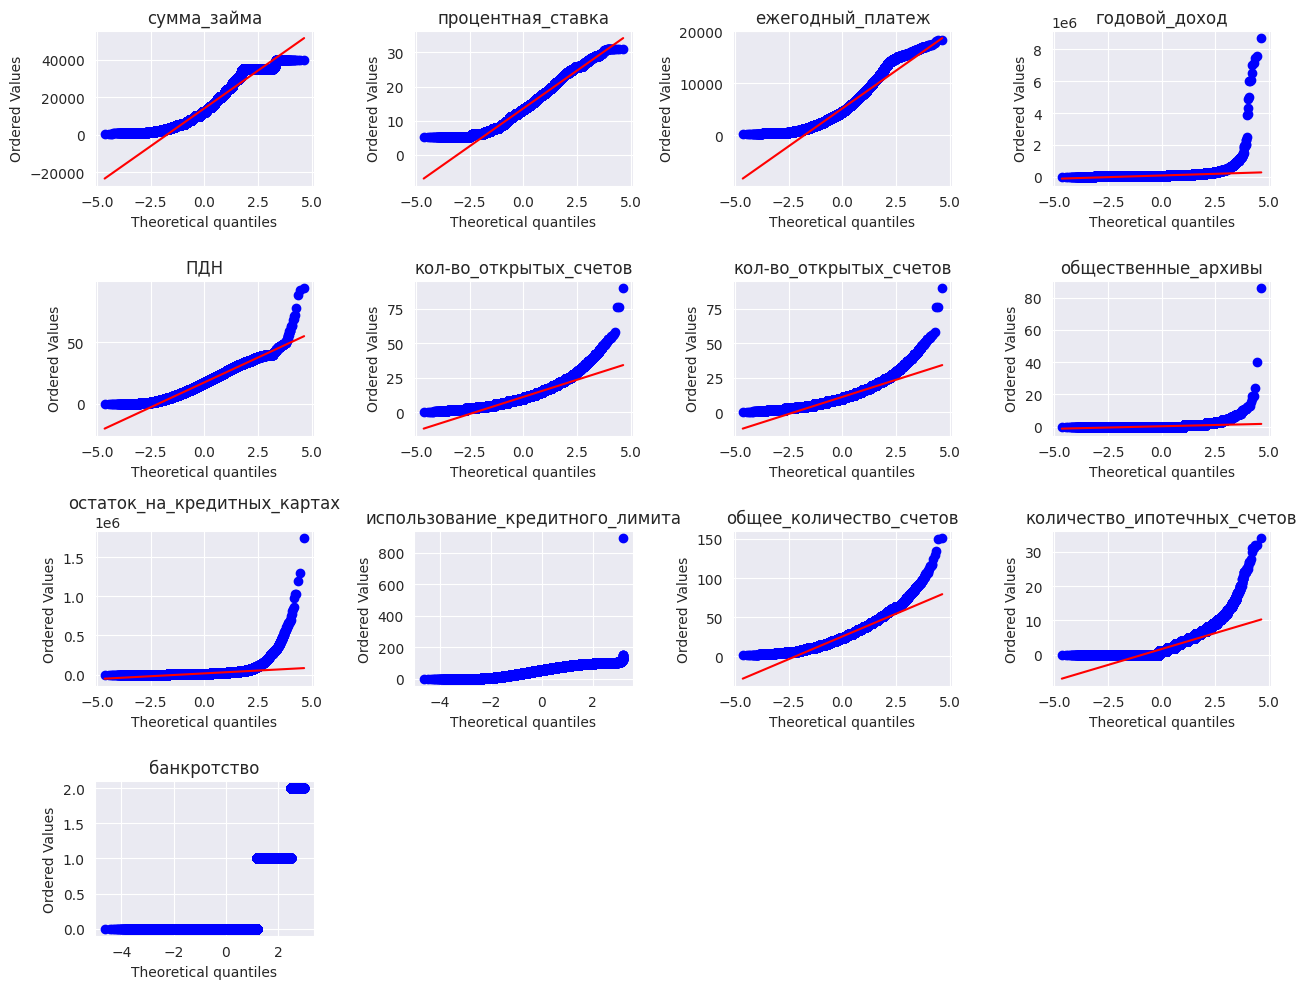

In [ ]:
plt.figure(figsize=(13, 10))

for i, var in enumerate(variables_to_test, start=1):
    data = df_copy[var]
    plt.subplot(4, 4, i)  # 3 строки и 4 колонки, переменная i определяет позицию подграфика
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(var)

plt.tight_layout()
plt.show()